In [16]:
#Developed in PyCharm with Python 3
#Using Kali Linux
#Chinmaya Joshi

#Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statistics as stats
import math

In [17]:
#Define Material Name, TIM Status, and Run Number
materialName = "PG"
TIMstate = "NoTIM"
RunNum = 3

In [18]:
#For organising output values
def prntl():
    print(" ")
    print("----------------------------------------------")
    print(" ")
    return 0

In [19]:
#Defining function to load data
#Function uses directory names as arguments and outputs all the TRT data for the Material, TIM  state, and Run Number
def loadRawData(materialName,stateTIM,setTests):
    setTests = "Run"+ str(setTests)
    #rawData = np.loadtxt("TRTDataForPaper/PG/NoTIM/Run1/Test 139.lvm", delimiter= '\t', skiprows=23, encoding='windows-1252')
    datasetTRT = []

    for testData in sorted(os.listdir("TRTDataForPaper/"+materialName+"/"+stateTIM+"/"+setTests)):
        rawData = np.loadtxt("TRTDataForPaper/"+materialName+"/"+stateTIM+"/"+setTests+"/"+testData, delimiter= '\t', skiprows=23, encoding='windows-1252')
        rawData = pd.DataFrame(rawData)
        datasetTRT.append(rawData)

    return datasetTRT, materialName



In [20]:
#Defining function for separating the time and temperature values from the raw data
def TRTDataLabel(datasetTRT):

    times = []
    H1s = []
    H2s = []
    H3s = []
    C3s = []
    C2s = []
    C1s = []

    for i in range(len(datasetTRT)):
        times.append(datasetTRT[i][0])
        H1s.append(datasetTRT[i][1])
        H2s.append(datasetTRT[i][2])
        H3s.append(datasetTRT[i][3])
        C3s.append(datasetTRT[i][4])
        C2s.append(datasetTRT[i][5])
        C1s.append(datasetTRT[i][6])

    return times, H1s, H2s, H3s, C3s, C2s, C1s

In [21]:
#Defining function for plotting Time vs Temp plots to see (manually) where steady state is achieved
def plotForSteadyState(labelledData):

    for i in range(len(labelledData[0])):
        plt.figure()
        plt.plot(labelledData[0][i], labelledData[1][i], label="H1", color="red") #Closest to Heater
        plt.plot(labelledData[0][i], labelledData[2][i], label="H2", color = "orange")
        plt.plot(labelledData[0][i], labelledData[3][i], label="H3", color = "yellow") #Closest to Hot Side on Sample
        plt.plot(labelledData[0][i], labelledData[4][i], label="C3", color = "green") #Closest to Cold Side on Sample
        plt.plot(labelledData[0][i], labelledData[5][i], label="C2", color = "pink")
        plt.plot(labelledData[0][i], labelledData[6][i], label="C1", color = "blue") #Closest to Cold Plate
        #plt.axvline(x = 1000, linestyle = "--", color = "red")
        #plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Temperature ($^{o}C$)")
        plt.title("Sample Thickness: " + str(sampleThicknesses[i]) + " metres")
        plt.show()

    return 0

In [22]:
#Multiply the time in seconds by 1000 since sample rate is 1000 Hz (1000 measurements/second)
#Function calculates the steady state temperatures for each test based on the user input of time steps at which steady state appears to be achieved
def steadyStateValues(labelledData, ssTimestep):
    ssH1 = []
    ssH2 = []
    ssH3 = []
    ssC3 = []
    ssC2 = []
    ssC1 = []

    #ssTImestep = [3000000, 1200000, 1000000, 1200000]

    for i in range(len(labelledData[0])):
        ssH1.append(np.mean(labelledData[1][i][ssTimestep[i]:]))
        ssH2.append(np.mean(labelledData[2][i][ssTimestep[i]:]))
        ssH3.append(np.mean(labelledData[3][i][ssTimestep[i]:]))
        ssC3.append(np.mean(labelledData[4][i][ssTimestep[i]:]))
        ssC2.append(np.mean(labelledData[5][i][ssTimestep[i]:]))
        ssC1.append(np.mean(labelledData[6][i][ssTimestep[i]:]))

    return ssH1, ssH2, ssH3, ssC3, ssC2, ssC1

In [23]:
#Defining function for plotting Time vs Temp plots after defining steady state
def plotWithSteadyState(labelledData, ssTimestep):

    for i in range(len(labelledData[0])):
        plt.figure()
        plt.plot(labelledData[0][i], labelledData[1][i],  color="red", label= "T1") #Closest to Heater
        plt.plot(labelledData[0][i], labelledData[2][i],  color = "orange", label= "T2")
        plt.plot(labelledData[0][i], labelledData[3][i],  color = "yellow", label= "T3") #Closest to Hot Side on Sample
        plt.plot(labelledData[0][i], labelledData[4][i],  color = "green", label= "T4") #Closest to Cold Side on Sample
        plt.plot(labelledData[0][i], labelledData[5][i],  color = "pink", label= "T5")
        plt.plot(labelledData[0][i], labelledData[6][i],  color = "blue", label= "T6") #Closest to Cold Plate
        plt.axvline(x = ssTimestep[i]/1000, color="red", linestyle="--")
        plt.legend(fontsize = 14)
        plt.xlabel("Time (s)", fontsize = 14)
        plt.ylabel("Temperature ($^{o}C$)", fontsize = 14)
        plt.title("Sample Thickness: " + str(sampleThicknesses[i] * (10**(3))) + " mm", fontsize = 14)
        plt.grid(True)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.show()

    return 0

In [24]:
#Defining function to generate and plot a temperature profile across the meter bars
def generateTemperatureProfile(ssValues, sampleThicknesses):

    sampleThicknesses = np.array(sampleThicknesses)

    linRegResults = []
    thermalResistances = []
    thermalConductivitiesofSample = []
    averageHeatFluxValues = []
    temperatureDifferenceSampleValues = []
    meterBarThermalConductivity = 167 #W/m K, for 6061 T6 Aluminium
    areaSample = 0.016*0.016 #Sample areas

    for i in range(len(ssValues[0])):

        thermocoupleLocations1 = [0.0044, 0.0180, 0.0316]
        thermocoupleLocations2 = [0.0360 + sampleThicknesses[i] + 0.0044, 0.0360 + sampleThicknesses[i] + 0.0180, 0.0360 + sampleThicknesses[i] + 0.0316]
        overallThermocoupleLocations = thermocoupleLocations1 + thermocoupleLocations2

        yMeterBar = 0.0360
        meterBarLength1 = np.linspace(0, 0.0360, 1000)
        meterBarLength2 = np.linspace(0.0360 + sampleThicknesses[i], 2*0.0360 + sampleThicknesses[i], 1000)

        ssHotSideTemps = [ssValues[0][i], ssValues[1][i], ssValues[2][i]]
        ssColdSideTemps = [ssValues[3][i], ssValues[4][i], ssValues[5][i]]

        linearRegressionLinesHot = np.polyfit(thermocoupleLocations1, ssHotSideTemps, 1)
        linearRegressionLinesCold = np.polyfit(thermocoupleLocations2, ssColdSideTemps, 1)

        linearRegressionLines = [linearRegressionLinesHot, linearRegressionLinesCold]
        linRegResults.append(linearRegressionLines)

        hotSidePredictions = linRegResults[i][0][0]*meterBarLength1 + linRegResults[i][0][1]
        coldSidePredictions = linRegResults[i][1][0]*meterBarLength2 + linRegResults[i][1][1]

        sampleHotSideTemp = np.polyval(linearRegressionLinesHot, yMeterBar)
        sampleColdSideTemp = np.polyval(linearRegressionLinesCold, yMeterBar + sampleThicknesses[i])

        temperatureGradientSample = (sampleHotSideTemp - sampleColdSideTemp)/sampleThicknesses[i]

        measuredHeatFluxHot = -meterBarThermalConductivity*linRegResults[i][0][0]
        measuredHeatFluxCold = -meterBarThermalConductivity*linRegResults[i][1][0]
        avgHeatFluxSystem = (measuredHeatFluxHot + measuredHeatFluxCold)/2

        thermalConductivitySample = avgHeatFluxSystem/temperatureGradientSample
        thermalResistanceSample = sampleThicknesses[i]/thermalConductivitySample

        thermalResistances.append(thermalResistanceSample)
        thermalConductivitiesofSample.append(thermalConductivitySample)
        #linearRegressionLines.append(linearRegressionLines)
        averageHeatFluxValues.append(avgHeatFluxSystem)
        temperatureDifferenceSampleValues.append(sampleHotSideTemp - sampleColdSideTemp)


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#Plotting

        plt.figure()
        plt.plot(np.array(meterBarLength1)*1000, hotSidePredictions, label="Hot Side Temperature Profile", color="red")
        plt.plot(np.array(meterBarLength2)*1000, coldSidePredictions, label="Cold Side Temperature Profile", color="blue")
        plt.plot(np.array(thermocoupleLocations1)*1000, ssHotSideTemps, "o", label="Measured Hot Side Temperature", color="red")
        plt.plot(np.array(thermocoupleLocations2)*1000, ssColdSideTemps, "o", label="Measured Cold Side Temperature", color="blue")
        plt.plot(yMeterBar*1000, sampleHotSideTemp, "x", label="Extrapolated Hot Side Temperature", color="red")
        plt.plot((yMeterBar + np.array(sampleThicknesses[i]))*1000, sampleColdSideTemp, "x", label="Extrapolated Cold Side Temperature", color="blue")
        plt.legend(loc="best")
        plt.grid(True)
        plt.xlabel("Distance Across Setup (mm)", fontsize= 14)
        plt.ylabel("Temperature ($^{o}C$)", fontsize= 14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        #plt.label
        plt.title("Pyrolytic Graphite Without TIM, " + "Sample Thickness: " + str(sampleThicknesses[i] * (10**(3))) + " mm", fontsize= 14, loc="center")
        plt.show()

        print("----------------------------------------")
        print("Sample Thickness: " + str(sampleThicknesses[i] * (10**(3))) + " mm")
        print("Hot Side Slope: " + str(linRegResults[i][0][0]))
        print("Cold Side Slope: " + str(linRegResults[i][1][0]))
        print("Extrapolated Hot Side Temperature: " + str(np.polyval(linearRegressionLinesHot, yMeterBar)) + " Celsius")
        print("Extrapolated Cold Side Temperature: " + str(np.polyval(linearRegressionLinesCold, yMeterBar + sampleThicknesses[i])) + " Celsius")
        print("Temperature Difference Across Sample")
        print("Measured Heat Flux at Hot Side: " + str(measuredHeatFluxHot) + " W/m2 ")
        print("Measured Heat Flux at Cold Side: " + str(measuredHeatFluxCold) + " W/m2 ")
        print("Average Heat Flux: " + str(avgHeatFluxSystem) + " W/m2 K")
        print("Thermal Resistance of Sample: " + str(thermalResistanceSample) + " m2 K/W")
        print("----------------------------------------")


    return thermalResistances, linRegResults, overallThermocoupleLocations, averageHeatFluxValues, temperatureDifferenceSampleValues, thermalConductivitiesofSample

In [25]:
#Defining function to plot the measured thermal resistance with a linear regression and calculate the thermal conductivity from the slope
def findThermalConductivity(sampleThicknesses, thermalResistanceValues):

    sampleThicknesses = np.array(sampleThicknesses)

    invThermalConductivity, thermalContactResistance = np.polyfit(sampleThicknesses, thermalResistanceValues, 1)
    thermalConductivity = 1/invThermalConductivity

    thermalResistancePredictions = invThermalConductivity*sampleThicknesses + thermalContactResistance
    thermalResistanceValues = np.array(thermalResistanceValues)
    thermalResistancePredictions = np.array(thermalResistancePredictions)

    plt.figure()
    plt.plot(sampleThicknesses*1000, thermalResistanceValues*1000, "o", label="Measured Thermal Resistance of Sample", color="red")
    plt.plot(sampleThicknesses*1000, thermalResistancePredictions*1000, label="Fit Line", color="red")
    plt.xlabel("Sample Thickness (mm)", fontsize= 14)
    plt.ylabel("Thermal Resistance ($m^{2}K/kW$)", fontsize= 14)
    plt.title("Thermal Resistance vs Sample Thickness", fontsize= 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

    print("----------------------------------------")
    print("Thermal Conductivity: " + str(thermalConductivity) + " W/m K")
    print("Thermal Contact Resistance: " + str(thermalContactResistance) + " m2 K/W")
    print("----------------------------------------")

    return thermalConductivity, invThermalConductivity, thermalContactResistance

In [26]:
#Using the Functions to load data
loadedRawData = loadRawData(materialName, TIMstate, RunNum)

datasetTRT = loadedRawData[0]
materialName = loadedRawData[1]

labelledData = TRTDataLabel(datasetTRT)
print(materialName)

PG


In [27]:
#Defining function for manually identified steady state values
def thicknessData(materialName):
    if materialName == "PG":
        sampleThicknesses = [0.00046, 0.00060, 0.00096, 0.00144, 0.00200, 0.00214, 0.00233, 0.00291, 0.00315] #For PG


        #ssTimestep = [3500, 3700, 1200, 1000, 1200, 1200, 1500, 800, 800 ]#WithTIM1
        #ssTimestep = [1600, 500, 400, 400, 1000, 300, 250, 800, 800 ]#WithTIM2
        #ssTimestep = [900, 500, 300, 350, 600, 800, 400, 400, 200 ]#WithTIM3


        #ssTimestep = [1700, 650, 1400, 850, 800, 650, 800, 600, 600 ] #NoTIM1
        #ssTimestep = [1100, 1000, 600, 900, 1000, 1200, 800, 1000, 1300 ] #NoTIM2
        ssTimestep = [1400, 800, 600, 600, 600, 600, 600, 800, 800 ] #NoTIM3

    elif materialName == "TiG2":
        sampleThicknesses = [0.00051, 0.00090, 0.00160, 0.00200] #For TiG2

        #sampleThicknesses = [ 0.00200, 0.00160, 0.00090, 0.00051] #For TiG2 with Reversed Thicknesses


        #ssTimestep = [3300, 1400, 1000, 1200] #WithTIM1
        #ssTimestep = [1000, 1600, 1300, 1300] #WithTIM2
        ssTimestep = [1600, 500, 600, 2500] #WithTIM3

        #ssTimestep = [2000, 800, 800, 1500] #NoTIM1
        #ssTimestep = [1200, 600, 700, 1400] #NoTIM2
        #ssTimestep = [500, 600, 1400, 1000] #NoTIM3



    ssTimestep = np.array(ssTimestep)  * 1000
    return sampleThicknesses, ssTimestep


sampleThicknesses = thicknessData(materialName)[0]
ssTimestep = thicknessData(materialName)[1]

print(ssTimestep)

ssValues = steadyStateValues(labelledData, ssTimestep)
print(ssValues)



[1400000  800000  600000  600000  600000  600000  600000  800000  800000]
([153.2836937596774, 156.97610255752807, 153.6150970634839, 150.49514200193553, 155.78384788558955, 153.87814004059706, 158.1040158101767, 161.7758613887923, 161.8746881032168], [148.69480645741933, 152.40782158044942, 149.21396143561293, 145.68822415193546, 151.6176627135371, 149.6130713771642, 153.79686950077738, 157.6382067905314, 158.04470998853148], [143.85016578451612, 147.50302468067417, 144.4543395994839, 140.98488917596774, 146.55300375545852, 144.81901163910445, 148.97553544749118, 152.81636554357488, 153.41747894405592], [103.70451563096773, 103.22197563056177, 73.72038796593549, 76.69129693225806, 65.91355184803494, 67.08421556507463, 65.9560670486219, 63.464552411594205, 58.53802262517482], [100.59210502387099, 100.10003076112358, 70.88916602554838, 73.42189915419354, 63.25797274253276, 64.23723500119402, 63.16167724636042, 60.76602469777777, 56.17908019356644], [98.19243652935484, 97.68741046719104,

/home/frost/Desktop/Python/pythonProject/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


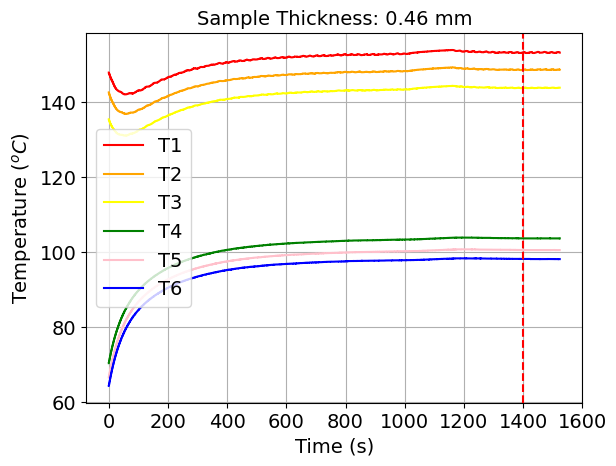

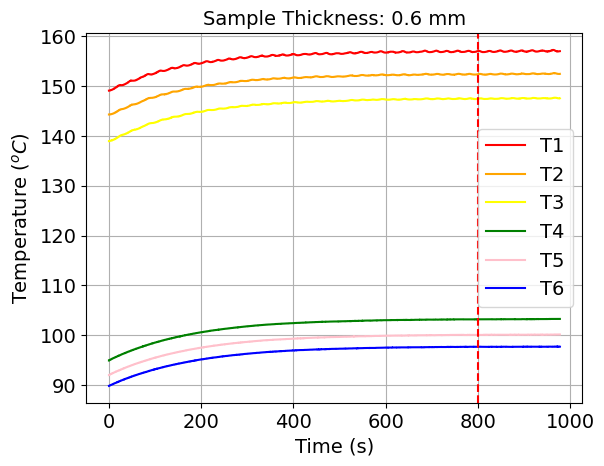

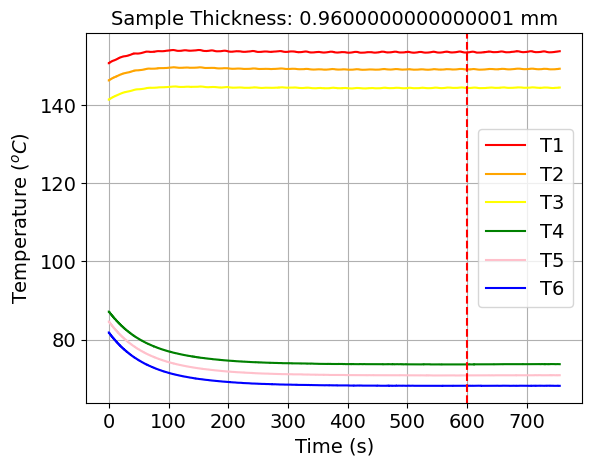

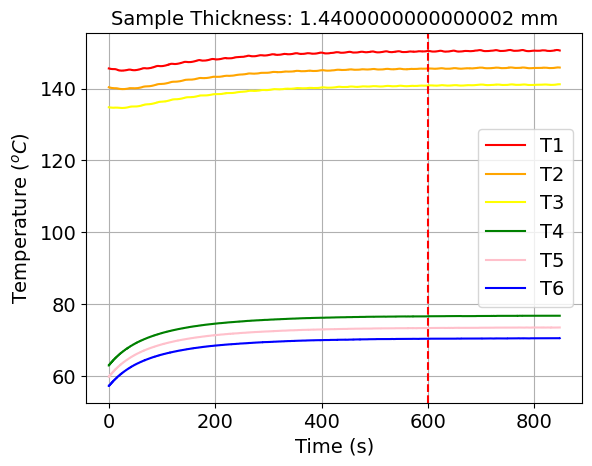

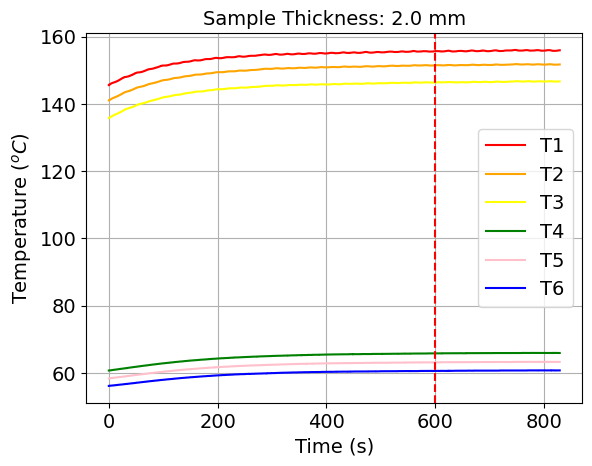

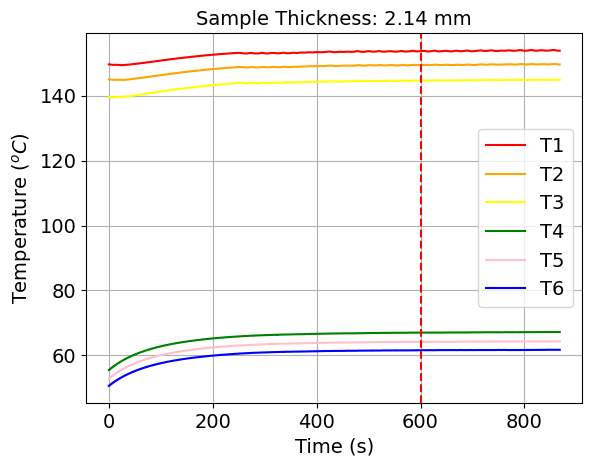

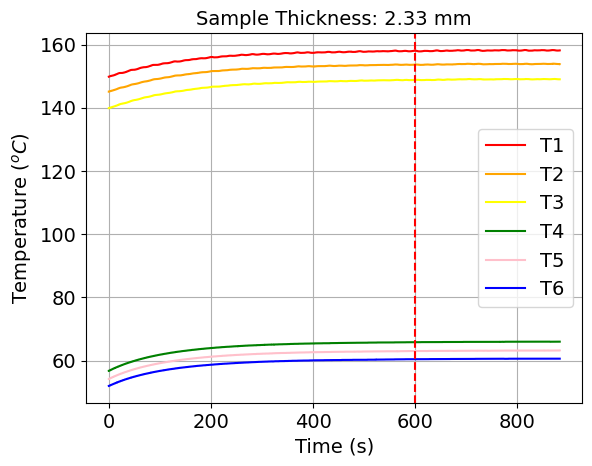

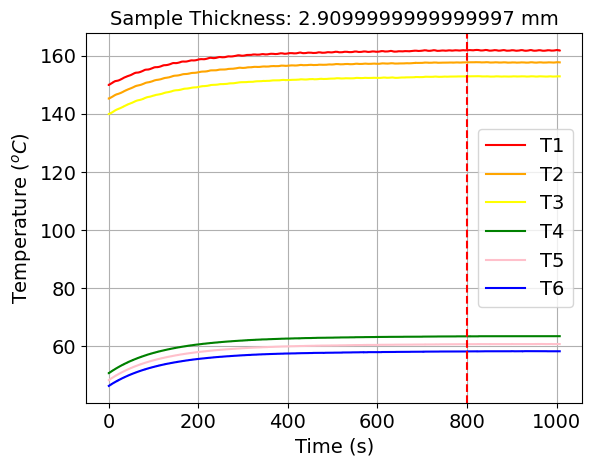

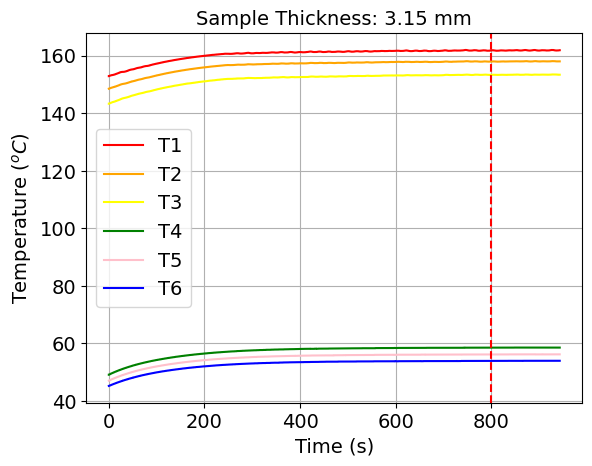

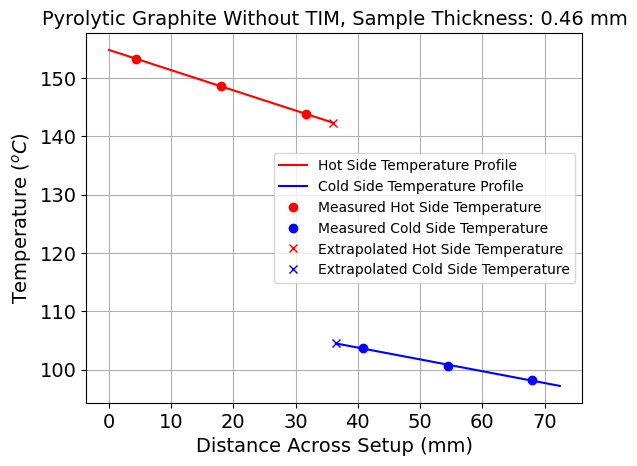

----------------------------------------
Sample Thickness: 0.46 mm
Hot Side Slope: -346.8208814397511
Cold Side Slope: -202.64996697106307
Extrapolated Hot Side Temperature: 142.3667794679553 Celsius
Extrapolated Cold Side Temperature: 104.47738513354369 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 57919.08720043843 W/m2 
Measured Heat Flux at Cold Side: 33842.544484167534 W/m2 
Average Heat Flux: 45880.81584230298 W/m2 K
Thermal Resistance of Sample: 0.0008258221576669714 m2 K/W
----------------------------------------


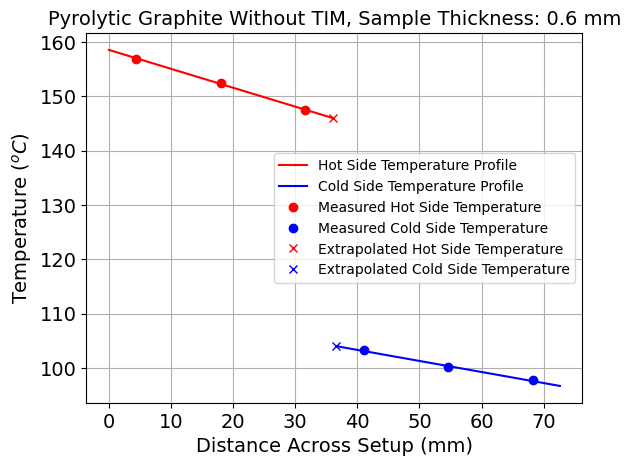

----------------------------------------
Sample Thickness: 0.6 mm
Hot Side Slope: -348.2749219431569
Cold Side Slope: -203.4766604180415
Extrapolated Hot Side Temperature: 146.02670101124033 Celsius
Extrapolated Cold Side Temperature: 103.99905217381686 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 58161.911964507206 W/m2 
Measured Heat Flux at Cold Side: 33980.60228981293 W/m2 
Average Heat Flux: 46071.25712716007 W/m2 K
Thermal Resistance of Sample: 0.0009122314314416048 m2 K/W
----------------------------------------


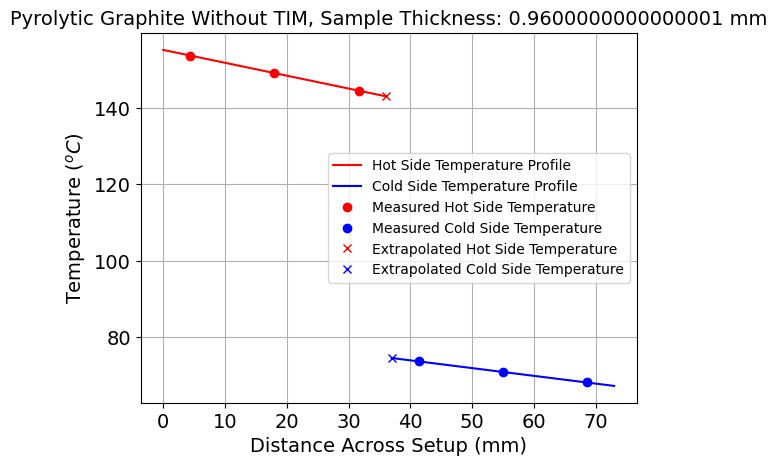

----------------------------------------
Sample Thickness: 0.9600000000000001 mm
Hot Side Slope: -336.79255382352716
Cold Side Slope: -202.7494181973425
Extrapolated Hot Side Temperature: 143.03220006403666 Celsius
Extrapolated Cold Side Temperature: 74.58787545503601 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 56244.35648852903 W/m2 
Measured Heat Flux at Cold Side: 33859.15283895619 W/m2 
Average Heat Flux: 45051.75466374261 W/m2 K
Thermal Resistance of Sample: 0.0015192377104922008 m2 K/W
----------------------------------------


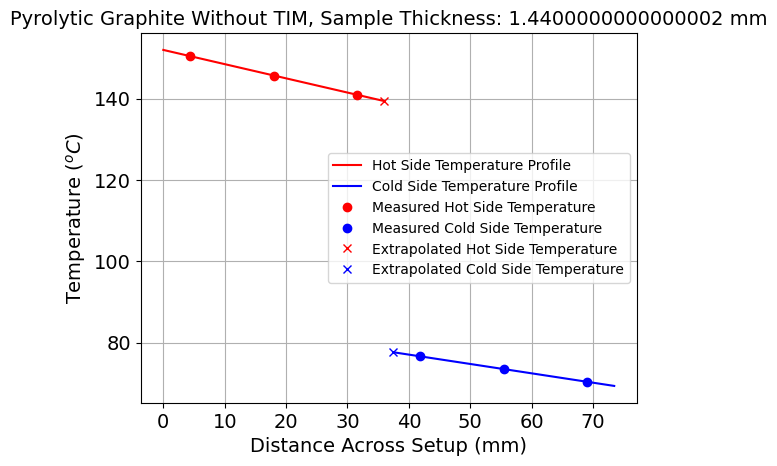

----------------------------------------
Sample Thickness: 1.4400000000000002 mm
Hot Side Slope: -349.6416480135186
Cold Side Slope: -230.2971193251899
Extrapolated Hot Side Temperature: 139.42920211236952 Celsius
Extrapolated Cold Side Temperature: 77.65881860554157 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 58390.155218257605 W/m2 
Measured Heat Flux at Cold Side: 38459.618927306714 W/m2 
Average Heat Flux: 48424.88707278216 W/m2 K
Thermal Resistance of Sample: 0.0012755916893308935 m2 K/W
----------------------------------------


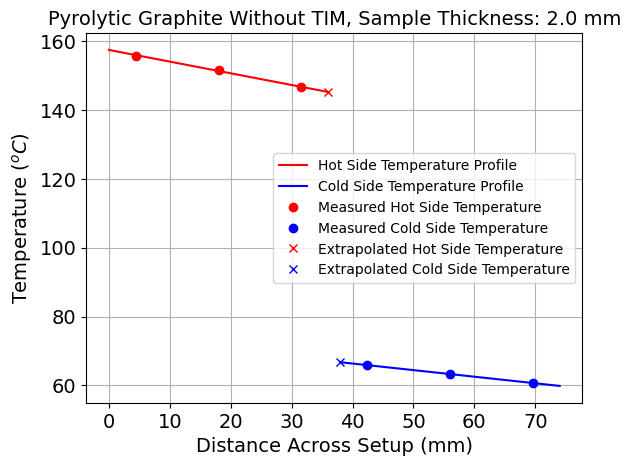

----------------------------------------
Sample Thickness: 2.0 mm
Hot Side Slope: -339.3692694901094
Cold Side Slope: -191.1364695735939
Extrapolated Hot Side Temperature: 145.20952460070637 Celsius
Extrapolated Cold Side Temperature: 66.73584460772496 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 56674.66800484827 W/m2 
Measured Heat Flux at Cold Side: 31919.79041879018 W/m2 
Average Heat Flux: 44297.22921181923 W/m2 K
Thermal Resistance of Sample: 0.0017715257001230983 m2 K/W
----------------------------------------


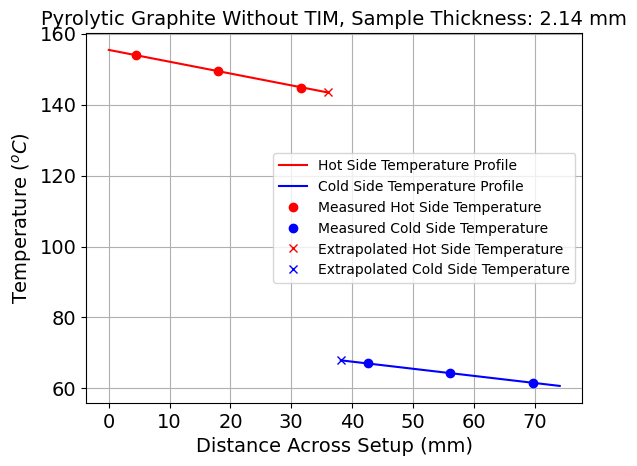

----------------------------------------
Sample Thickness: 2.14 mm
Hot Side Slope: -333.0561912313442
Cold Side Slope: -200.42137782045683
Extrapolated Hot Side Temperature: 143.44172957679092 Celsius
Extrapolated Cold Side Temperature: 67.92565301897719 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 55620.38393563448 W/m2 
Measured Heat Flux at Cold Side: 33470.37009601629 W/m2 
Average Heat Flux: 44545.37701582539 W/m2 K
Thermal Resistance of Sample: 0.0016952618120391156 m2 K/W
----------------------------------------


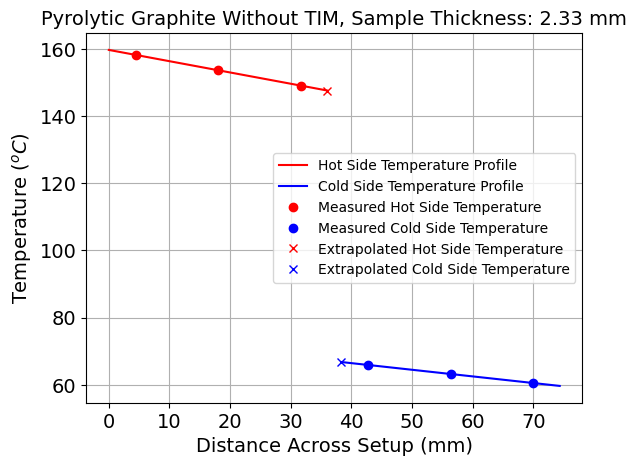

----------------------------------------
Sample Thickness: 2.33 mm
Hot Side Slope: -335.6058956869655
Cold Side Slope: -197.4322679640406
Extrapolated Hot Side Temperature: 147.58456746378295 Celsius
Extrapolated Cold Side Temperature: 66.78833204168016 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 56046.18457972324 W/m2 
Measured Heat Flux at Cold Side: 32971.18874999478 W/m2 
Average Heat Flux: 44508.68666485901 W/m2 K
Thermal Resistance of Sample: 0.0018152913841399398 m2 K/W
----------------------------------------


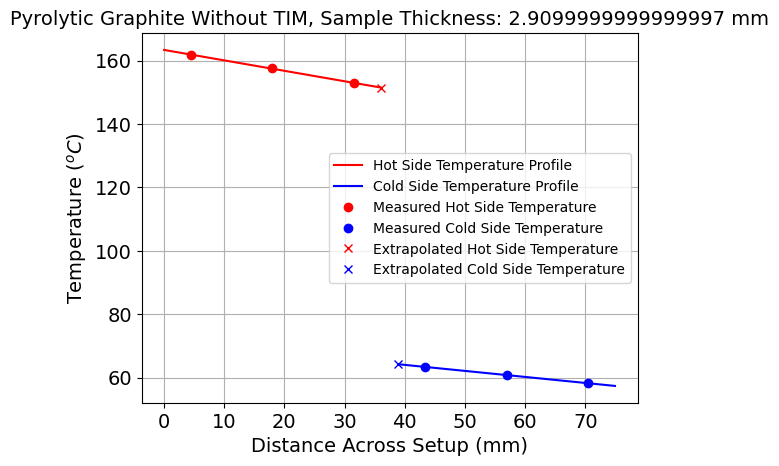

----------------------------------------
Sample Thickness: 2.9099999999999997 mm
Hot Side Slope: -329.393229603579
Cold Side Slope: -189.95567081557195
Extrapolated Hot Side Temperature: 151.48106644143502 Celsius
Extrapolated Cold Side Temperature: 64.26198049960779 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 55008.669343797694 W/m2 
Measured Heat Flux at Cold Side: 31722.597026200514 W/m2 
Average Heat Flux: 43365.633184999104 W/m2 K
Thermal Resistance of Sample: 0.002011248989948976 m2 K/W
----------------------------------------


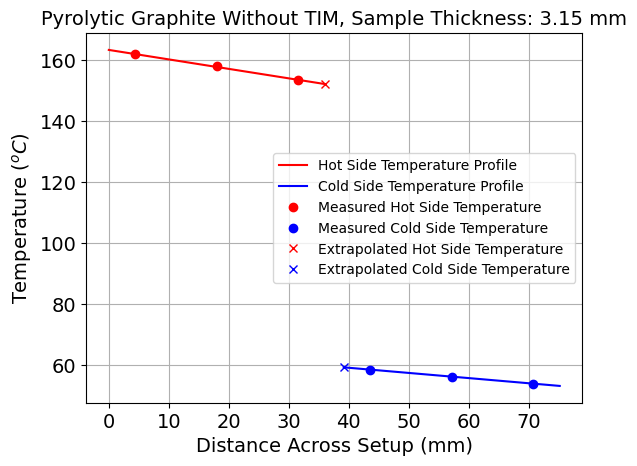

----------------------------------------
Sample Thickness: 3.15 mm
Hot Side Slope: -310.9268073220892
Cold Side Slope: -169.34042187371378
Extrapolated Hot Side Temperature: 152.1822764801371 Celsius
Extrapolated Cold Side Temperature: 59.26448291671055 Celsius
Temperature Difference Across Sample
Measured Heat Flux at Hot Side: 51924.776822788896 W/m2 
Measured Heat Flux at Cold Side: 28279.850452910203 W/m2 
Average Heat Flux: 40102.31363784955 W/m2 K
Thermal Resistance of Sample: 0.0023170182748690205 m2 K/W
----------------------------------------


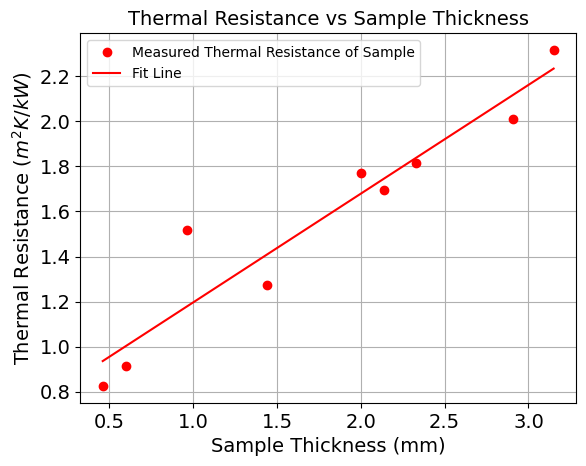

----------------------------------------
Thermal Conductivity: 2.072332138076892 W/m K
Thermal Contact Resistance: 0.0007141427261858111 m2 K/W
----------------------------------------


In [28]:
#Using previously defined functions to calculate thermal conductivity

plotWithSteadyState(labelledData, ssTimestep)

linearRegressionData = generateTemperatureProfile(ssValues, sampleThicknesses)
deltaTSample = linearRegressionData[4]

meterBarRegressions = np.array(linearRegressionData[1])
overallThermocoupleLocations = np.array(linearRegressionData[2])

thermalResistanceValues = linearRegressionData[0]

averageHeatFlux = np.array(linearRegressionData[3])
temperatureDifferenceSample = np.array(linearRegressionData[4])

thermalConductivitiesofSamples = np.array(linearRegressionData[5])


runTC = findThermalConductivity(sampleThicknesses, thermalResistanceValues)

thermalConductivities = runTC[0]
invThermalConductivities = runTC[1]
thermalContactResistances = runTC[2]


In [29]:
print(thermalResistanceValues)


[0.0008258221576669714, 0.0009122314314416048, 0.0015192377104922008, 0.0012755916893308935, 0.0017715257001230983, 0.0016952618120391156, 0.0018152913841399398, 0.002011248989948976, 0.0023170182748690205]


In [30]:
#Function provides statistically important data for error analysis (Mean and Standard Deviation)
def statisticalData(labelledData,ssTimestep):
    avgH1, stdevH1 = [],[]
    avgH2, stdevH2 = [],[]
    avgH3, stdevH3 = [],[]
    avgC3, stdevC3 = [],[]
    avgC2, stdevC2 = [],[]
    avgC1, stdevC1 = [],[]

    numMeasurements = []


    for i in range(len(labelledData[0])):
        numMeasurements.append(len(labelledData[0][i][ssTimestep[i]:]))
        avgH1.append(np.mean(labelledData[1][i][ssTimestep[i]:]))
        stdevH1.append(stats.stdev(labelledData[1][i][ssTimestep[i]:]))

        avgH2.append(np.mean(labelledData[2][i][ssTimestep[i]:]))
        stdevH2.append(stats.stdev(labelledData[2][i][ssTimestep[i]:]))

        avgH3.append(np.mean(labelledData[3][i][ssTimestep[i]:]))
        stdevH3.append(stats.stdev(labelledData[3][i][ssTimestep[i]:]))

        avgC3.append(np.mean(labelledData[4][i][ssTimestep[i]:]))
        stdevC3.append(stats.stdev(labelledData[4][i][ssTimestep[i]:]))

        avgC2.append(np.mean(labelledData[5][i][ssTimestep[i]:]))
        stdevC2.append(stats.stdev(labelledData[5][i][ssTimestep[i]:]))

        avgC1.append(np.mean(labelledData[6][i][ssTimestep[i]:]))
        stdevC1.append(stats.stdev(labelledData[6][i][ssTimestep[i]:]))

        averages = [avgH1, avgH2, avgH3, avgC3, avgC2, avgC1]
        stdevs = [stdevH1, stdevH2, stdevH3, stdevC3, stdevC2, stdevC1]

    averages = np.array(averages)
    stdevs = np.array(stdevs)
    numMeasurements = np.array(numMeasurements)

    return averages, stdevs, numMeasurements

averageValues, standardDeviationValues, numMeasurements = statisticalData(labelledData, ssTimestep)

In [31]:
print(averageValues)
print(standardDeviationValues)
print((numMeasurements))

[[153.28369376 156.97610256 153.61509706 150.495142   155.78384789
  153.87814004 158.10401581 161.77586139 161.8746881 ]
 [148.69480646 152.40782158 149.21396144 145.68822415 151.61766271
  149.61307138 153.7968695  157.63820679 158.04470999]
 [143.85016578 147.50302468 144.4543396  140.98488918 146.55300376
  144.81901164 148.97553545 152.81636554 153.41747894]
 [103.70451563 103.22197563  73.72038797  76.69129693  65.91355185
   67.08421557  65.95606705  63.46455241  58.53802263]
 [100.59210502 100.10003076  70.88916603  73.42189915  63.25797274
   64.237235    63.16167725  60.7660247   56.17908019]
 [ 98.19243653  97.68741047  68.20560379  70.42721529  60.71463988
   61.63275409  60.58590936  58.29775817  53.93196315]]
[[0.08661104 0.1004111  0.09070942 0.11602382 0.11276302 0.10915599
  0.10338778 0.07950347 0.06446324]
 [0.05443217 0.06883508 0.06546014 0.0992504  0.10241351 0.09426862
  0.09400816 0.05045641 0.04686774]
 [0.04652516 0.06087974 0.05209826 0.09819913 0.1113033  0.

In [32]:
#Uncertainty of mean = Root Squared of STDEVs x numMeasurements
# https://phys.libretexts.org/Courses/Georgia_State_University/GSU-TM-Physics_I_(2211)/01%3A_Introduction_to_Physics_and_Measurements/1.03%3A_Measurements_Uncertainty_and_Significant_Figures
#Standard Uncertainty calculated using the method above
#This is Standard Uncertainty

def calculateStandardUncertainty(averageValues, standardDeviationValues, numMeasurements):

    standarUncertaintyH1, standarUncertaintyH2, standarUncertaintyH3, standarUncertaintyC3, standarUncertaintyC2, standarUncertaintyC1 = [],[],[],[],[],[]

    for i in range(len(averageValues[0])):
        standarUncertaintyH1.append(standardDeviationValues[0][i]/np.sqrt(numMeasurements[i]))
        standarUncertaintyH2.append(standardDeviationValues[1][i]/np.sqrt(numMeasurements[i]))
        standarUncertaintyH3.append(standardDeviationValues[2][i]/np.sqrt(numMeasurements[i]))
        standarUncertaintyC3.append(standardDeviationValues[3][i]/np.sqrt(numMeasurements[i]))
        standarUncertaintyC2.append(standardDeviationValues[4][i]/np.sqrt(numMeasurements[i]))
        standarUncertaintyC1.append(standardDeviationValues[5][i]/np.sqrt(numMeasurements[i]))

    standardUncertainty = [standarUncertaintyH1, standarUncertaintyH2, standarUncertaintyH3, standarUncertaintyC3, standarUncertaintyC2, standarUncertaintyC1]
    standardUncertainty = np.array(standardUncertainty)

    return standardUncertainty


standardUncertaintyValues = calculateStandardUncertainty(averageValues, standardDeviationValues, numMeasurements)
print(standardUncertaintyValues)




[[2.45958825e-04 2.37997143e-04 2.30402163e-04 2.32981440e-04
  2.35639963e-04 2.10853183e-04 1.94346173e-04 1.74743458e-04
  1.70468490e-04]
 [1.54576970e-04 1.63154793e-04 1.66268926e-04 1.99299607e-04
  2.14012672e-04 1.82095725e-04 1.76714552e-04 1.10899916e-04
  1.23938434e-04]
 [1.32122589e-04 1.44298813e-04 1.32329715e-04 1.97188594e-04
  2.32589601e-04 1.64338407e-04 1.82184881e-04 8.54857431e-05
  1.12834972e-04]
 [2.84345675e-05 5.85977463e-05 5.82598074e-05 9.88511480e-05
  9.04428546e-05 1.13426622e-04 9.54043409e-05 3.05582400e-05
  4.98944396e-05]
 [3.16692352e-05 4.64136567e-05 4.70954008e-05 9.65506496e-05
  8.62164297e-05 9.70194611e-05 9.74980460e-05 3.95020261e-05
  5.07968879e-05]
 [3.99710249e-05 3.57589735e-05 2.59268154e-05 8.30996495e-05
  9.96018954e-05 7.01517666e-05 1.03527889e-04 5.47820923e-05
  4.68463618e-05]]


In [33]:
#For Temperature uncertainty
#T type thermocouple error = +-1 C for 0 - 350 C
thermocoupleUncertainty = 1 #C


#Combining the Thermocouple Uncertainties
combinedUncertainty = np.sqrt(standardUncertaintyValues**2 + thermocoupleUncertainty**2)

uTemperature = combinedUncertainty

print(uTemperature)



[[1.00000003 1.00000003 1.00000003 1.00000003 1.00000003 1.00000002
  1.00000002 1.00000002 1.00000001]
 [1.00000001 1.00000001 1.00000001 1.00000002 1.00000002 1.00000002
  1.00000002 1.00000001 1.00000001]
 [1.00000001 1.00000001 1.00000001 1.00000002 1.00000003 1.00000001
  1.00000002 1.         1.00000001]
 [1.         1.         1.         1.         1.         1.00000001
  1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.00000001 1.         1.        ]]


In [34]:
#For Positional Uncertainty of Thermocouples
uHoleTC = (1.00 - 0.81)/2
uCalipers = 0.01/math.sqrt(3)

uPositional = np.sqrt(uHoleTC**2 + uCalipers**2)

print(uPositional)

0.09517527690179486


In [35]:
def matrixTranspose(matrix):
    inputMatrix = np.array(matrix)
    outputMatrix = inputMatrix.transpose()
    return outputMatrix

ssValuesByTest = matrixTranspose(ssValues)

In [36]:
print(ssValuesByTest)
print(overallThermocoupleLocations[0:3])
print(len(overallThermocoupleLocations))
print(sampleThicknesses)
print(" ")
print(meterBarRegressions)
print(" ")
print(meterBarRegressions[0][0], meterBarRegressions[0][1])

[[153.28369376 148.69480646 143.85016578 103.70451563 100.59210502
   98.19243653]
 [156.97610256 152.40782158 147.50302468 103.22197563 100.10003076
   97.68741047]
 [153.61509706 149.21396144 144.4543396   73.72038797  70.88916603
   68.20560379]
 [150.495142   145.68822415 140.98488918  76.69129693  73.42189915
   70.42721529]
 [155.78384789 151.61766271 146.55300376  65.91355185  63.25797274
   60.71463988]
 [153.87814004 149.61307138 144.81901164  67.08421557  64.237235
   61.63275409]
 [158.10401581 153.7968695  148.97553545  65.95606705  63.16167725
   60.58590936]
 [161.77586139 157.63820679 152.81636554  63.46455241  60.7660247
   58.29775817]
 [161.8746881  158.04470999 153.41747894  58.53802263  56.17908019
   53.93196315]]
[0.0044 0.018  0.0316]
6
[0.00046, 0.0006, 0.00096, 0.00144, 0.002, 0.00214, 0.00233, 0.00291, 0.00315]
 
[[[-346.82088144  154.8523312 ]
  [-202.64996697  111.86600293]]

 [[-348.27492194  158.5645982 ]
  [-203.47666042  111.44629795]]

 [[-336.79255382 

In [37]:
#Calculating Regression Uncertainty for THot and TCold
def temperatureRegressionUncertainty(sampleThicknesses, actualTemperatures, thermocoupleLocations, regression):

    tPredHot, tPredCold = [], []
    resHot, resCold = [], []
    uncertaintyHot, uncertaintyCold = [], []

    tPredictedSet = []
    residualsSet = []
    uncertaintiesSet = []


    numTests = len(sampleThicknesses)
    numThermocouples = len(thermocoupleLocations)
    thermocouplePerMeterBar = numThermocouples/2

    for i in range(numTests):
        sampleThickness = sampleThicknesses[i]

        for j in range(3):
            k = j+3

            predictedTemperatureHotBar = regression[i][0][0] * thermocoupleLocations[j] + regression[i][0][1]
            predictedTemperatureColdBar = regression[i][1][0] * thermocoupleLocations[k] + regression[i][1][1]
            tPredHot.append(predictedTemperatureHotBar)
            tPredCold.append(predictedTemperatureColdBar)
            tPredByTest = tPredHot + tPredCold


            residualsHot = np.array(actualTemperatures[i][j] - predictedTemperatureHotBar)
            residualsCold = np.array(actualTemperatures[i][k] - predictedTemperatureColdBar)
            resHot.append(residualsHot)
            resCold.append(residualsCold)
            residualsByTest = [resHot, resCold]

        resHot, resCold = [], []
        residualsSet.append(residualsByTest)

        tPredHot, tPredCold = [], []
        tPredictedSet.append(tPredByTest)

        tPredicted = np.array(tPredictedSet)
        residualsCalculated = np.array(residualsSet)

    squaredResiduals = residualsCalculated**2

    for l in range(len(sampleThicknesses)):
        hotUncertainty = (np.sum(squaredResiduals[l][0]))
        coldUncertainty = (np.sum(squaredResiduals[l][1]))
        uncertaintyHot.append(hotUncertainty)
        uncertaintyCold.append(coldUncertainty)
        uncertaintyByTest = [uncertaintyHot, uncertaintyCold]

    uncertaintiesSet.append(uncertaintyByTest)
    uncertainties = np.array(uncertaintiesSet)

    return tPredicted, residualsCalculated, uncertainties

temperatureRegressionUncertaintyData = temperatureRegressionUncertainty(sampleThicknesses, ssValuesByTest, overallThermocoupleLocations, meterBarRegressions)

tPredicted = temperatureRegressionUncertaintyData[0]
residuals = temperatureRegressionUncertaintyData[1]
temperaturePredictionUncertainties = temperatureRegressionUncertaintyData[2][0]


print("Actual Temperatures:")
print(ssValuesByTest)
prntl()
print("Predicted Temperatures:")
print(tPredicted)
prntl()
print(residuals)
prntl()
print("Uncertainty in Temperature Prediction for Linear Regression Across Meter Bars:")
print(temperaturePredictionUncertainties)
print("uThot is Row 1, uTCold is Row 2")
prntl()
print("Delta T Across Sample:")
print(deltaTSample)




Actual Temperatures:
[[153.28369376 148.69480646 143.85016578 103.70451563 100.59210502
   98.19243653]
 [156.97610256 152.40782158 147.50302468 103.22197563 100.10003076
   97.68741047]
 [153.61509706 149.21396144 144.4543396   73.72038797  70.88916603
   68.20560379]
 [150.495142   145.68822415 140.98488918  76.69129693  73.42189915
   70.42721529]
 [155.78384789 151.61766271 146.55300376  65.91355185  63.25797274
   60.71463988]
 [153.87814004 149.61307138 144.81901164  67.08421557  64.237235
   61.63275409]
 [158.10401581 153.7968695  148.97553545  65.95606705  63.16167725
   60.58590936]
 [161.77586139 157.63820679 152.81636554  63.46455241  60.7660247
   58.29775817]
 [161.8746881  158.04470999 153.41747894  58.53802263  56.17908019
   53.93196315]]
 
----------------------------------------------
 
Predicted Temperatures:
[[153.32631932 148.60955533 143.89279135 103.04059687 100.28455732
   97.52851777]
 [157.03218854 152.29564961 147.55911067 102.58488938  99.8176068
   97.0503

In [38]:
#Defining function for calculating the uncertainty in the predicted temperatures from the linear regression thermal gradient
def temperatureGradientUncertainty(thermocoupleLocations, temperaturePredictionUncertainty):

    numMeasurements = 3

    sigmaXiSquared = np.sum(np.array(thermocoupleLocations**2))
    sigmaXiWholeSquared = (np.sum(np.array(thermocoupleLocations)))**2

    numerator = (numMeasurements*(temperaturePredictionUncertainty**2))
    denominator = ((numMeasurements*sigmaXiSquared) - sigmaXiWholeSquared)

    print("sigmaXiSquared:", sigmaXiSquared)
    print("sigmaXiWholeSquared:", sigmaXiWholeSquared)
    print("numerator:", numerator)
    print("denominator:", denominator)
    prntl()

    uncertaintyTemperatureGradient =   np.sqrt(numerator/denominator)

    return uncertaintyTemperatureGradient

uncertainties2 = temperatureGradientUncertainty(overallThermocoupleLocations[0:3], temperaturePredictionUncertainties)

print(uncertainties2)
prntl()
print("For a 90% confidence interval, the uncertainty in the temperature gradient measurement is:")
uncertainty90 = uncertainties2 * 1.886
print(uncertainty90)



sigmaXiSquared: 0.0013419200000000001
sigmaXiWholeSquared: 0.0029160000000000006
numerator: [[3.56536682e-04 1.06866412e-03 1.37628559e-03 9.59335645e-06
  5.43050723e-02 6.52547503e-03 5.82513019e-03 1.82606879e-02
  3.36669093e-02]
 [2.85867582e+00 2.38442942e+00 1.06242648e+00 6.84971273e-01
  6.48668216e-02 5.28512601e-02 2.24962753e-02 6.81483927e-04
  1.30310801e-05]]
denominator: 0.00110976
 
----------------------------------------------
 
[[ 0.56681009  0.98130967  1.11362699  0.09297598  6.99528905  2.42488715
   2.29106961  4.05643044  5.50791325]
 [50.75372477 46.35298455 30.94104015 24.84400714  7.6453395   6.90101767
   4.50236579  0.78363401  0.10836167]]
 
----------------------------------------------
 
For a 90% confidence interval, the uncertainty in the temperature gradient measurement is:
[[ 1.06900384  1.85075004  2.1003005   0.1753527  13.19311515  4.57333717
   4.32095729  7.65042782 10.38792438]
 [95.72152492 87.42172886 58.35480172 46.85579746 14.41911031 13.0

In [39]:
print("Average Heat Flux Calculation in the Setup is:")
print(averageHeatFlux)
prntl()
print("Temperature Difference Across Sample:")
print(temperatureDifferenceSample)
prntl()
print("Calculated Thermal Resistance Values:")
print(thermalResistanceValues)
prntl()
print("Calculated Thermal Conductivity Values:")
print(thermalConductivities)


Average Heat Flux Calculation in the Setup is:
[45880.8158423  46071.25712716 45051.75466374 48424.88707278
 44297.22921182 44545.37701583 44508.68666486 43365.633185
 40102.31363785]
 
----------------------------------------------
 
Temperature Difference Across Sample:
[37.88939433 42.02764884 68.44432461 61.77038351 78.47367999 75.51607656
 80.79623542 87.21908594 92.91779356]
 
----------------------------------------------
 
Calculated Thermal Resistance Values:
[0.0008258221576669714, 0.0009122314314416048, 0.0015192377104922008, 0.0012755916893308935, 0.0017715257001230983, 0.0016952618120391156, 0.0018152913841399398, 0.002011248989948976, 0.0023170182748690205]
 
----------------------------------------------
 
Calculated Thermal Conductivity Values:
2.072332138076892


In [40]:
#Uncertainty in Heat FLux Calculation
#k = 167 W/m K for 6061 T6 Aluminium
uHeatFlux = np.sqrt(((-167*uncertainty90)**2))
print("Uncertainty in Heat Flux Calculation at Each Meter Bar:")
print(uHeatFlux)
prntl()
print("Uncertainty in the Average Heat Flux Calculation in the Setup is:")
uAverageHeatFlux = (np.sqrt((uHeatFlux[0])**2 + (uHeatFlux[1])**2))/2
print(uAverageHeatFlux)
prntl()
print("Uncertainty in the Temperature Difference Across Sample:")
uTDiff = (np.sqrt((temperaturePredictionUncertainties[0]**2) + (temperaturePredictionUncertainties[1]**2)))/2
print(uTDiff)
prntl()
print("Uncertainty in the Thermal Resistance Measurement is:")
uThermalResistance = thermalResistanceValues * (np.sqrt((uTDiff/deltaTSample)**2 + (uAverageHeatFlux/averageHeatFlux)**2))
print(uThermalResistance)

Uncertainty in Heat Flux Calculation at Each Meter Bar:
[[  178.52364078   309.07525732   350.75018367    29.28390011
   2203.25023021   763.74730704   721.5998666   1277.6214456
   1734.78337192]
 [15985.49466196 14599.42871926  9745.25188757  7824.91817599
   2407.99142116  2173.55832757  1418.07413367   246.81493448
     34.129807  ]]
 
----------------------------------------------
 
Uncertainty in the Average Heat Flux Calculation in the Setup is:
[7993.24574685 7301.34998551 4875.7809642  3912.48648584 1631.92633575
 1151.91859004  795.55650586  650.62165852  867.5595356 ]
 
----------------------------------------------
 
Uncertainty in the Temperature Difference Across Sample:
[0.48811136 0.44586041 0.29774189 0.23891785 0.09965436 0.07034246
 0.04858104 0.03973052 0.05297794]
 
----------------------------------------------
 
Uncertainty in the Thermal Resistance Measurement is:
[1.44265559e-04 1.44893537e-04 1.64554118e-04 1.03179399e-04
 6.53024254e-05 4.38669561e-05 3.24652

In [41]:
#Calculating Uncertainty for Linear Regression of Thermal Resistances
#invertedThermalConductivities = 1/thermalConductivitiesofSamples

def thermalResistanceUncertainties(thermalResistanceValues, invertedThermalConductivities, thermalContactResistances, sampleThicknesses):

    sampleThicknesses = np.array(sampleThicknesses)
    invertedThermalConductivities = np.array(invertedThermalConductivities)
    thermalContactResistances = np.array(thermalContactResistances)
    thermalResistanceValues = np.array(thermalResistanceValues)

    uncertaintyRth = []


    actualThermalResistance = thermalResistanceValues
    predictedThermalResistance = invertedThermalConductivities*sampleThicknesses + thermalContactResistances
    residuals = np.array(actualThermalResistance - predictedThermalResistance)
    residualsSquared = residuals**2

    numerator = np.sum(residualsSquared)
    denominator = len(thermalResistanceValues) - 2

    uRth = np.sqrt(numerator/denominator)



        #print("Actual Thermal Resistance:", actualThermalResistance)
        #print("Predicted Thermal Resistance:", predictedThermalResistance)
        #print("Residuals:", residuals)
        #print("Uncertainty in the Thermal Resistance Prediction is:", uRth)


    #print(len(thermalResistanceValues))

    return uRth

uncertaintyThermalResistance = thermalResistanceUncertainties(thermalResistanceValues, invThermalConductivities, thermalContactResistances, sampleThicknesses)

print(uncertaintyThermalResistance)


0.00016267140018789733


In [42]:
#Inverse Thermal Conductivity Regression Uncertainty
#Calculating Regression Uncertainty for Rth

def inverseThermalConductivityUncertainty(sampleThicknesses, uncertaintiesThermalResistances):

    sampleThicknesses = np.array(sampleThicknesses)



    numerator = (len(sampleThicknesses)) * ((uncertaintiesThermalResistances)**2)
    denominator = (len(sampleThicknesses) * np.sum(sampleThicknesses**2)) - np.sum(sampleThicknesses)**2

    uncertaintyInverseThermalConductivity = np.sqrt(numerator/denominator)

    uncertaintyInverseThermalConductivity = uncertaintyInverseThermalConductivity * 1.886

    print(uncertaintyInverseThermalConductivity)

    return uncertaintyInverseThermalConductivity

delta1OverKMaterial = inverseThermalConductivityUncertainty(sampleThicknesses, uncertaintyThermalResistance)




0.11160359441735873


In [43]:
#Defining function for thermal conductivity uncertainty calculation
def thermalConductivityUncertainty(uncertaintyInvertedTC, invertedTC, thermalConductivities):

    numerator = (uncertaintyInvertedTC)
    denominator = (invertedTC)

    uncertaintyInThermalConductivity = thermalConductivities * (np.sqrt( ((-1 * numerator/denominator) )**2))

    print(uncertaintyInThermalConductivity)

    return uncertaintyInThermalConductivity

thermalConductivityUncertaintyCalculated = thermalConductivityUncertainty(delta1OverKMaterial, invThermalConductivities, thermalConductivities)



0.479288387183283
